In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import keras
from sklearn.metrics import f1_score
import cv2
from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping,CSVLogger, TensorBoard
from numpy.random import seed
seed(42)
from numpy.random import seed
seed(42)
from keras.applications.vgg16 import VGG16



Using TensorFlow backend.


In [2]:
datapath = "dataset/"
img_width, img_height = 224,224
classes = ["manipuri", "bharatanatyam", "odissi", "kathakali", "kathak", "sattriya", "kuchipudi", "mohiniyattam"]
class_names_label = {classes:i for i, classes in enumerate(set(classes))}
num_classes = len(classes)
model_try='vgg'

In [3]:
def load_images(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height),interpolation=cv2.INTER_CUBIC)
    return resized

def norm_images(images):
#     images = np.array(images,dtype = 'float32') / 255.  
#     mean_img = np.mean(images,axis = 0)
#     std_img = np.std(images,axis = 0)
#     norm_img = (images - mean_img)/std_img
#     return norm_img
    return images

def load_dataset(folder_name):
    images = []
    labels = []
    label_file = pd.read_csv(os.path.join(datapath,folder_name+".csv"))
    for file in tqdm(os.listdir(os.path.join(datapath,folder_name))):
        if file == ".DS_Store":
            continue
        
        if(folder_name == "train"):
            label = class_names_label[label_file[label_file["Image"] == file]["target"].values[0]]
            labels.append(label)
        else:
            labels.append(file)
        image = load_images(os.path.join(datapath,folder_name,file))
#         image = norm_images(image)
        images.append(image)
    images = np.array(images,dtype = 'float32')
#     images = norm_images(images)
    return (images,labels)

In [4]:
def show_batch(image_batch, label_batch):
    y_maps = dict()
    y_maps = {v:k for k,v in class_names_label.items()}
#     print(y_maps)
    plt.figure(figsize=(12,12))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        pred = np.argmax(label_batch[n])
#         print(pred)
        plt.title(y_maps[pred])
        plt.axis('off')

In [5]:
def generate_sol(name, model, x_test):
    predictions = model.predict(x_test)#/255.)
    predictions = np.argmax(predictions,axis = 1)
    y_maps = dict()
    y_maps = {v:k for k,v in class_names_label.items()}
    print(y_maps)
    print(predictions)
    pred_labels = [y_maps[k] for k in predictions]
    print(pred_labels)
    sub = pd.DataFrame({'Image':img_name,'target':pred_labels})
#     model.save('weights/'+name+'weights.h5')
    sub.to_csv('solutions_experiment/'+name+'sol.csv', index = False)

In [6]:
(x_train, y_train)=load_dataset("train")
x_train,y_train = shuffle(x_train,y_train,random_state = 42)
(x_test, img_name) = load_dataset("test")
y_train = np.array(y_train, dtype = 'int16')
y_train = to_categorical(y_train)
 
print(y_train.shape)

100%|██████████| 156/156 [00:00<00:00, 206.87it/s]


(557, 8)


In [7]:
print(y_train)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

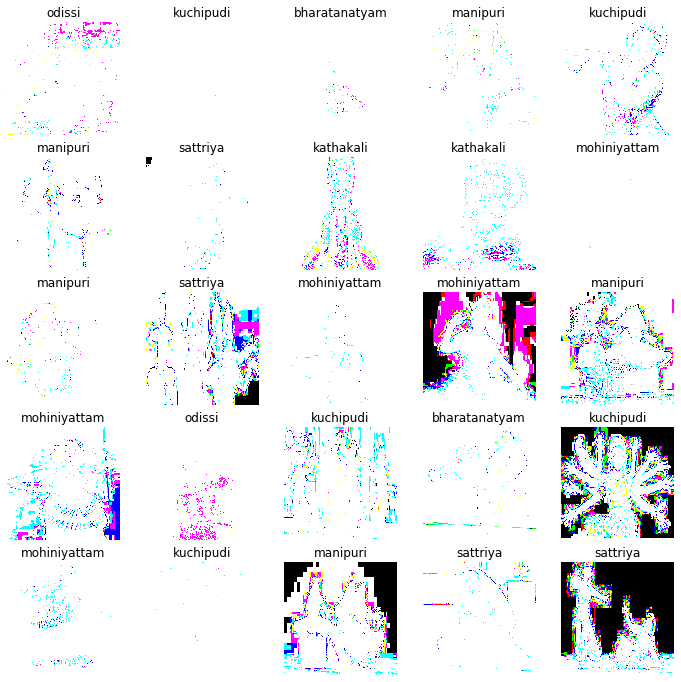

In [8]:
show_batch(x_train,y_train)

In [9]:
from keras.applications.vgg16 import preprocess_input
datagen = ImageDataGenerator(preprocessing_function = preprocess_input,rotation_range = 40, width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=[0.2,1.0],
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.3,
#         brightness_range = [1,1.3]
                            )
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow(x_train, y_train,subset="training",batch_size=32)
val_generator = datagen.flow(x_train, y_train,subset = "validation", batch_size=32)
#val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


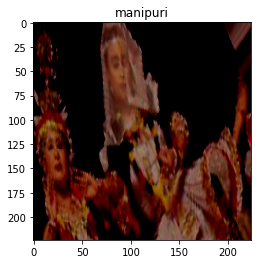

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


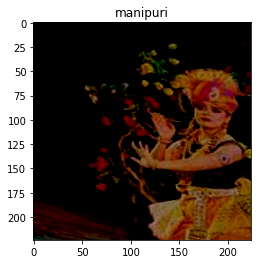

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


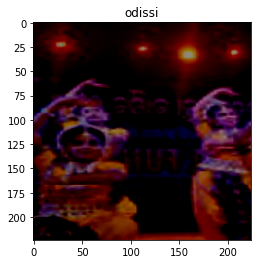

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


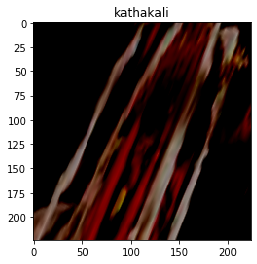

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


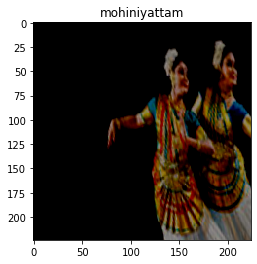

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


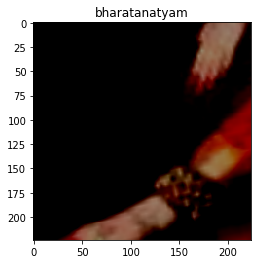

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


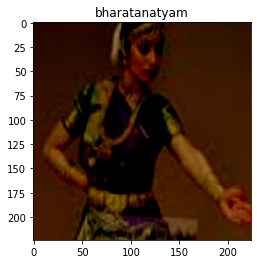

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


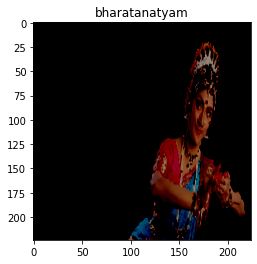

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


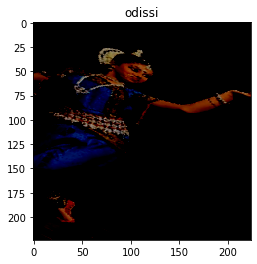

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


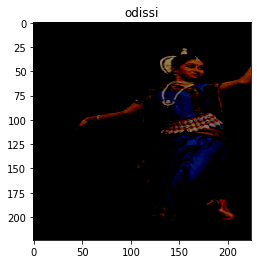

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


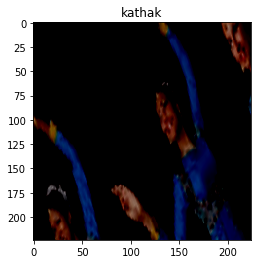

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


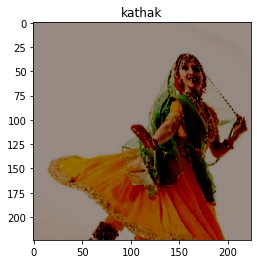

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


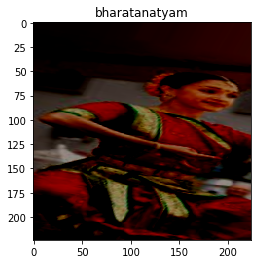

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


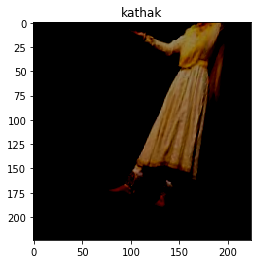

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


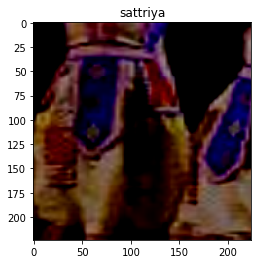

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


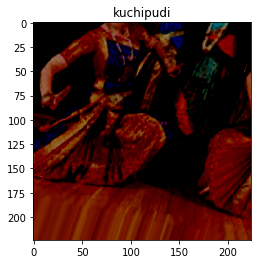

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


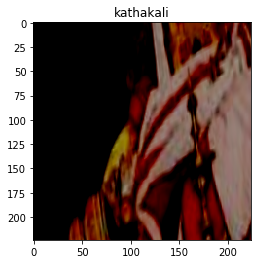

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


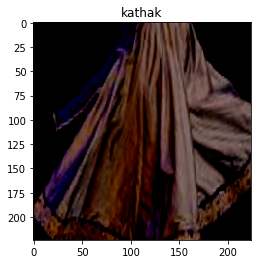

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


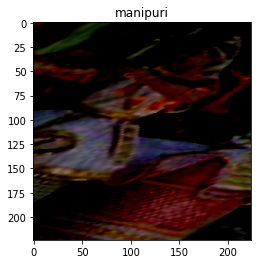

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


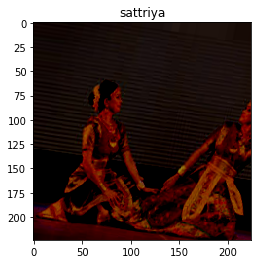

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


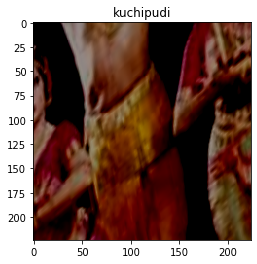

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


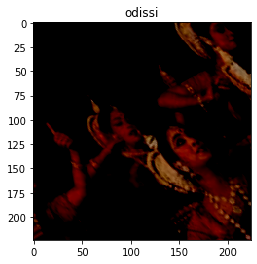

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


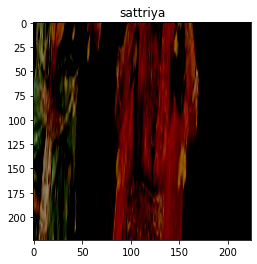

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


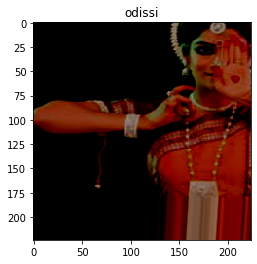

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


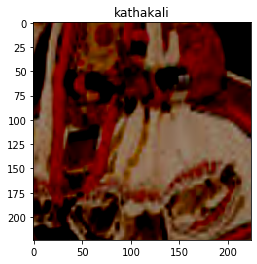

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


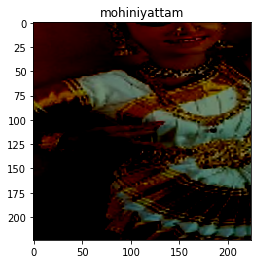

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


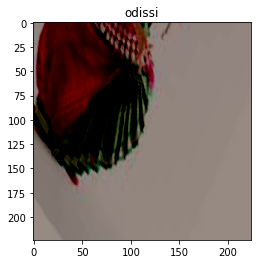

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


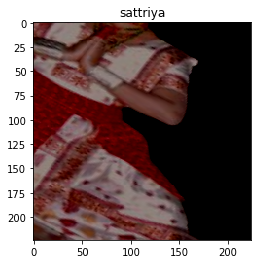

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


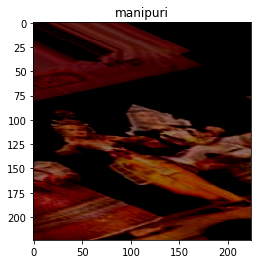

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


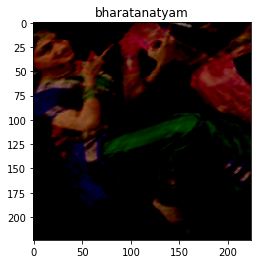

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


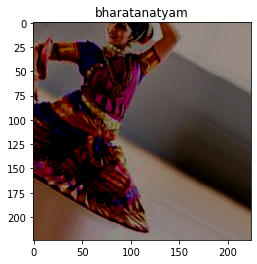

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


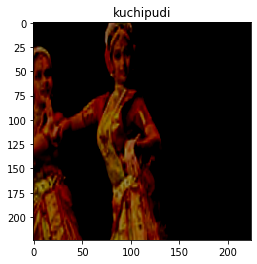

In [10]:
x_batch, y_batch = next(train_generator)
for i in range (0,32):
    y_maps = dict()
    y_maps = {v:k for k,v in class_names_label.items()}
#   
    image = x_batch[i]
    plt.title(y_maps[np.argmax(y_batch[i])])
#     print(image.shape)
    plt.imshow(image)
    plt.show()


In [11]:
from keras.models import load_model
if model_try=='inceptionv3':
    pretrained_model = InceptionV3(input_shape = (img_width, img_height,3),include_top = False, weights = 'imagenet')
    for layer in pretrained_model.layers:
        layer.trainable = False

else:
    pretrained_model =VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3),pooling='avg')

 # Print the model summary
    pretrained_model.summary()
    pretrained_model.trainable = False
# 
model_v3 = Sequential()
model_v3.add(pretrained_model)
#pretrained_model)
# model_v3.add(Flatten())
model_v3.add(Dense(256,activation = 'relu'))
model_v3.add(Dropout(0.3))
model_v3.add(Dense(y_train.shape[1],activation = 'softmax'))
# model_v3 = load_model("weights/inceptionv3_150weights.h5")
model_v3.compile(optimizer = Adam(lr = 0.0001),loss = 'categorical_crossentropy',metrics = ['accuracy'])
model_v3.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
early_stops = EarlyStopping(patience=3, monitor='val_accuracy')

history = model_v3.fit(x_train, y_train,batch_size =128, epochs=50, validation_split=0.3, callbacks=[early_stops])



Train on 389 samples, validate on 168 samples
Epoch 1/50
389/389 [==============================] - 42s 108ms/step - loss: 11.2976 - accuracy: 0.1337 - val_loss: 8.3956 - val_accuracy: 0.0893
Epoch 2/50
389/389 [==============================] - 47s 121ms/step - loss: 10.2549 - accuracy: 0.1517 - val_loss: 7.2865 - val_accuracy: 0.1310
Epoch 3/50
389/389 [==============================] - 61s 156ms/step - loss: 9.3898 - accuracy: 0.1594 - val_loss: 6.5735 - val_accuracy: 0.1012
Epoch 4/50
389/389 [==============================] - 68s 174ms/step - loss: 9.0848 - accuracy: 0.1440 - val_loss: 6.0992 - val_accuracy: 0.1012
Epoch 5/50
389/389 [==============================] - 61s 156ms/step - loss: 8.5572 - accuracy: 0.1645 - val_loss: 5.7935 - val_accuracy: 0.1131


In [15]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
pretrained_model.trainable = True
for layer in pretrained_model.layers[:-5]:
    layer.trainable = False

    # early_stops = EarlyStopping(patience=3, monitor='val_accuracy')

# model_v3.fit(x_train, y_train, batch_size=100, epochs=50, validation_split=0.3, callbacks=[early_stops])
model_v3.compile(optimizer = Adam(lr = 0.0001/10),loss = 'categorical_crossentropy',metrics = ['accuracy'])
history_fine = model_v3.fit(x_train, y_train, validation_split = 0.3, initial_epoch= history.epoch[-1], epochs = 30, callbacks=[early_stops])
 

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((model_predictions.shape[0])-2):
    plt.subplot(6,5,n+1)
    plt.imshow(val_batch_data[n])
    color = 'green' if np.argmax(model_predictions[n]) == np.argmax(val_batch_label[n]) else 'red'
    plt.title(dataset_labels[np.argmax(model_predictions[n])], color=color)
    plt.axis('off')
    _ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

In [ ]:
#bottleneck_features_train = model_v3.predict_generator(train_generator, 512, verbose = 1)
# import numpy as np
# train_labels = np.array([0] * 32 + [1] * 32 + [2] * 32 + [3] * 32 + [4] * 32 + [5] * 32 + [6] * 32 + [7] * 32)
# bottleneck_features_validation = model_v3.predict_generator(val_generator, 64)
# validation_labels = np.array([0] * 8 + [1] * 8 + [2] * 8 + [3] * 8 + [4] * 8 + [5] * 8 + [6] * 8 + [7] * 8)




In [ ]:
callbacks_list = [
#         ModelCheckpoint(top_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
#         EarlyStopping(monitor='val_acc', patience=5, verbose=0),
        ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.7)   ]
history = model_v3.fit_generator(train_generator, epochs=50, steps_per_epoch = 32,
                          validation_data=val_generator,
                                 validation_steps=32,
                                 verbose=2,callbacks=callbacks_list)

In [ ]:
# x_test = x_test/255.
generate_sol(model_try,model_v3,x_test)
# generate_sol("inceptionv3_150", model_v3)

In [ ]:
from sklearn.metrics import multilable_confusion_matrix


In [ ]:
pretrained_model.trainable = True
model_v3.summary()



In [ ]:
model_v3.compile(
    optimizer=Adam(1e-7),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

epochs = 10
model_v3.fit_generator(train_generator, epochs=epochs,
                          validation_data=val_generator, verbose=1)

In [ ]:

generate_sol("vgg_finetune", model_v3,x_test)
# generate_sol("inceptionv3_150_finetune", model_v3)